Séquentialisation des textes

Importation du fichier .csv adapté pour le nombre de fichier avec lesquels on travail

In [ ]:
import os
import pandas as pd

# Charger le CSV
df = pd.read_csv('training_set_metadata.csv', sep=';')
folder_path = "destination"

# Vérifier les fichiers JSON
missing_files = []
for idx, row in df.iterrows():
    json_path = os.path.join(folder_path, f"{row['name']}.json")
    if not os.path.exists(json_path):
        missing_files.append(row['name'])

# Afficher les fichiers manquants
if missing_files:
    print("Fichiers manquants :")
    for file in missing_files:
        print(f"- {file}")
else:
    print("Tous les fichiers sont présents.")

# Optionnel : Mettre à jour le CSV pour ne conserver que les fichiers existants
if missing_files:
    df_updated = df[~df['name'].isin(missing_files)]
    df_updated.to_csv("your_data_updated.csv", index=False)
    print("Fichier CSV mis à jour pour ne conserver que les fichiers existants.")

(Optionel: permet de déplacer les fichiers .json dans un autre répertoir)

In [ ]:
import os
import shutil

def move_json_files(source_directory, destination_directory):
    # Créer le répertoire de destination s'il n'existe pas
    os.makedirs(destination_directory, exist_ok=True)

    # Parcourir tous les fichiers dans le répertoire source
    for filename in os.listdir(source_directory):
        if filename.endswith(".json"):
            # Vérifier si le fichier est un fichier de mapping ou de matrice d'adjacence
            if "_assembly_mapping.json" in filename or "_adj_matrix.npz" in filename:
                continue  # Ignorer ces fichiers

            # Déplacer le fichier .json vers le répertoire de destination
            shutil.move(os.path.join(source_directory, filename), os.path.join(destination_directory, filename))
            print(f"Déplacé : {filename}")

# Utilisation des dossiers "graphes" et "destination"
source_directory = "graphes"
destination_directory = "destination"
move_json_files(source_directory, destination_directory)


Extraction du texte + vectorisation

In [ ]:
import os
import re
import networkx as nx
import numpy as np
import spacy
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.sparse import vstack, save_npz, load_npz
import gc
from tqdm import tqdm

# Expressions régulières pour extraire arêtes et nœuds
EDGE_REGEX = re.compile(r'"([a-zA-Z0-9]+)"\s*->\s*"([a-zA-Z0-9]+)"')
NODE_REGEX = re.compile(r'"([a-zA-Z0-9]+)"\s*\[label\s*=\s*"(.*?)"\s*\]')

def parse_cfg_file(cfg_path):
    try:
        with open(cfg_path, "r", encoding="utf-8", errors="ignore") as f:
            return [line.strip() for line in f if line.strip()]
    except Exception as e:
        print(f"Erreur lors de la lecture du fichier {cfg_path}: {e}")
        return []

def process_file(name, directory):
    """
    Lit un fichier JSON, construit un graphe avec NetworkX et extrait les instructions via DFS.
    Retourne une liste d'instructions (chaînes de caractères) ou None en cas d'erreur.
    """
    cfg_path = os.path.join(directory, f"{name}.json")
    if not os.path.exists(cfg_path):
        print(f"Le fichier {cfg_path} n'existe pas.")
        return None
    try:
        G = nx.DiGraph()
        lines = parse_cfg_file(cfg_path)
        if not lines:
            print(f"Le fichier {cfg_path} est vide ou n'a pas pu être lu.")
            return None

        # Extraction des arêtes et des nœuds
        for line in lines:
            if '->' in line:
                edge_match = EDGE_REGEX.match(line)
                if edge_match:
                    src, dst = edge_match.groups()
                    G.add_edge(src, dst)
            if "[" in line and "]" in line:
                node_match = NODE_REGEX.match(line)
                if node_match:
                    node, label = node_match.groups()
                    G.add_node(node, label=label)

        # Extraction des instructions via DFS
        instructions = []
        for node in nx.dfs_preorder_nodes(G):
            if 'label' in G.nodes[node]:
                instructions.append(G.nodes[node]['label'])
        print(f"Fichier {name}.json: {G.number_of_nodes()} nœuds, {G.number_of_edges()} arêtes.")
        return instructions

    except Exception as e:
        print(f"Erreur lors du traitement de {cfg_path}: {e}")
        return None

def batched(iterable, batch_size):
    """Générateur qui découpe un itérable en lots de taille batch_size."""
    batch = []
    for item in iterable:
        batch.append(item)
        if len(batch) == batch_size:
            yield batch
            batch = []
    if batch:
        yield batch

def process_graphs_in_directory(directory, batch_size=100):
    files = [f for f in os.listdir(directory) if f.endswith(".json")]
    partial_files = []  # Pour enregistrer le nom des fichiers de batch
    batch_index = 0

    # Chargement du modèle SpaCy (si besoin pour d'autres traitements)
    nlp = spacy.load('en_core_web_sm')

    # Traitement par lots avec barre de progression
    for batch_files in tqdm(list(batched(files, batch_size)), desc="Traitement par batch"):
        docs = []  # Liste des documents (texte brut) du batch
        with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
            futures = {executor.submit(process_file, os.path.splitext(filename)[0], directory): filename 
                       for filename in batch_files}
            for future in as_completed(futures):
                try:
                    result = future.result()
                    if result:
                        docs.append(" ".join(result))
                except Exception as e:
                    print(f"Erreur lors du traitement d'un fichier: {e}")
        gc.collect()

        if docs:
            # Utilisation du HashingVectorizer pour obtenir une matrice TF du batch
            hv = HashingVectorizer(n_features=2**20, alternate_sign=False, norm=None)
            batch_matrix = hv.transform(docs)
            # Enregistrement du batch sur disque
            batch_file = os.path.join(directory, f"tf_batch_{batch_index}.npz")
            save_npz(batch_file, batch_matrix)
            partial_files.append(batch_file)
            print(f"Batch {batch_index} enregistré : forme {batch_matrix.shape}")
            batch_index += 1

    # Si au moins un batch a été traité, on combine toutes les matrices
    if partial_files:
        matrices = [load_npz(f) for f in partial_files]
        full_tf_matrix = vstack(matrices)
        transformer = TfidfTransformer()
        tfidf_matrix = transformer.fit_transform(full_tf_matrix)
        final_file = os.path.join(directory, "tfidf_matrix.npz")
        save_npz(final_file, tfidf_matrix)
        print("Matrice TF-IDF finale de forme :", tfidf_matrix.shape)
    else:
        print("Aucun document traité.")

if __name__ == '__main__':
    directory = "destination"
    process_graphs_in_directory(directory, batch_size=100)













Modèle de prédiction

Traitement des données et préparations pour les modeles + modele de classification multi labelling

In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.multiclass import OneVsRestClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import MultiLabelBinarizer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

def charger_donnees(csv_path, matrix_path):
    """Charge les données depuis un fichier CSV et une matrice TF-IDF."""
    try:
        # Charger le fichier CSV
        df = pd.read_csv(csv_path, sep=';')

        # Charger la matrice TF-IDF
        X = load_npz(matrix_path)
        print("Matrice TF-IDF chargée de forme :", X.shape)

        # Extraire les colonnes cibles
        colonnes_cibles = df.columns.difference(['name'])
        y = df[colonnes_cibles].values

        # Binariser les cibles multi-labels
        mlb = MultiLabelBinarizer()
        y_binarized = mlb.fit_transform(y)
        print("Cibles binarisées de forme :", y_binarized.shape)

        # Aligner les données
        if X.shape[0] != y_binarized.shape[0]:
            print(f"Alignement des données : Suppression de {X.shape[0] - y_binarized.shape[0]} lignes de la matrice TF-IDF.")
            X = X[:y_binarized.shape[0]]

        # Appliquer SMOTE pour équilibrer les classes
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, y_binarized)

        return train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

    except Exception as e:
        print(f"Erreur lors du chargement des données : {e}")
        return None

def entrainer_et_evaluer_modele(modele, grille_param, X_train, y_train, X_test, y_test):
    """Entraîne un modèle en utilisant GridSearchCV et évalue ses performances."""
    f1_scorer = make_scorer(f1_score, average='macro')

    recherche_grille = GridSearchCV(estimator=OneVsRestClassifier(modele), param_grid=grille_param,
                                    scoring=f1_scorer, cv=3, verbose=1, n_jobs=1)
    recherche_grille.fit(X_train, y_train)

    print(f"Meilleurs paramètres pour {modele.__class__.__name__} :", recherche_grille.best_params_)
    print(f"Meilleur score F1 pour {modele.__class__.__name__} :", recherche_grille.best_score_)

    # Visualisation des résultats
    visualiser_resultats(recherche_grille, modele.__class__.__name__)

    y_pred = recherche_grille.predict(X_test)
    print(f"Score F1 macro pour {modele.__class__.__name__} :", f1_score(y_test, y_pred, average='macro'))

def visualiser_resultats(recherche_grille, nom_modele):
    """Visualise les résultats de la recherche des hyperparamètres."""
    results = recherche_grille.cv_results_
    plt.figure(figsize=(10, 6))
    plt.plot(results['mean_test_score'], label='Score moyen')
    plt.xlabel('Index de l\'itération')
    plt.ylabel('Score F1 Macro')
    plt.title(f'Évolution du score F1 Macro pour {nom_modele}')
    plt.legend()
    plt.show()

def principal():
    # Définir les chemins des fichiers
    csv_path = 'your_data_updated.csv'
    matrix_path = 'destination/tfidf_matrix.npz'

    # Charger les données
    donnees = charger_donnees(csv_path, matrix_path)
    if donnees:
        X_train, X_test, y_train, y_test = donnees

        # Définir les grilles de paramètres
        grille_param_lgb = {
            'estimator__n_estimators': [100, 200],
            'estimator__learning_rate': [0.01, 0.1],
            'estimator__num_leaves': [31, 50],
            'estimator__scale_pos_weight': [1, 2, 5]  # Ajout pour gérer le déséquilibre
        }

        grille_param_xgb = {
            'estimator__n_estimators': [100, 200],
            'estimator__learning_rate': [0.01, 0.1],
            'estimator__max_depth': [3, 5]
        }

        # Initialiser les modèles
        modele_lgb = lgb.LGBMClassifier()
        modele_xgb = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

        # Entraîner et évaluer les modèles
        entrainer_et_evaluer_modele(modele_lgb, grille_param_lgb, X_train, y_train, X_test, y_test)
        entrainer_et_evaluer_modele(modele_xgb, grille_param_xgb, X_train, y_train, X_test, y_test)
    else:
        print("Échec du chargement des données.")

if __name__ == "__main__":
    principal()







Modele MLP

Importation des bibliotheques 

In [3]:
import pandas as pd
import numpy as np
from scipy.sparse import load_npz, issparse, csr_matrix, save_npz
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping




Chargement et Prétraitement des Données

In [4]:
def charger_donnees(csv_path='your_data_updated.csv', matrix_path='destination/tfidf_matrix.npz', variance_threshold=0.95):
    """Charge les données depuis un fichier CSV et une matrice TF-IDF, applique Truncated SVD."""
    try:
        # Charger le fichier CSV
        df = pd.read_csv(csv_path, sep=';')

        # Charger la matrice TF-IDF
        X = load_npz(matrix_path)
        print("Matrice TF-IDF chargée de forme :", X.shape)

        # Convertir en matrice creuse si ce n'est pas le cas
        if not issparse(X):
            X = csr_matrix(X)

        # Réduction de dimensionnalité avec Truncated SVD
        svd = TruncatedSVD(n_components=min(X.shape[1], 300))
        X_reduced = svd.fit_transform(X)

        # Calculer la variance expliquée
        explained_variance = np.cumsum(svd.explained_variance_ratio_)
        print("Variance expliquée pour les 10 premières dimensions :", explained_variance[:10])

        # Sélectionner le nombre de composants qui capture au moins 'variance_threshold' de la variance
        n_components = np.argmax(explained_variance >= variance_threshold) + 1
        print(f"Nombre de composants sélectionnés pour capturer {variance_threshold*100}% de la variance : {n_components}")

        # Réduire à nouveau la matrice avec le nombre optimal de composants
        svd = TruncatedSVD(n_components=n_components)
        X_reduced = svd.fit_transform(X)
        print("Matrice TF-IDF réduite de forme :", X_reduced.shape)

        # Enregistrer la matrice creuse
        save_npz('reduced_tfidf_matrix.npz', csr_matrix(X_reduced))

        # Extraire les colonnes cibles
        colonnes_cibles = df.columns.difference(['name'])
        y = df[colonnes_cibles].values

        # Binariser les cibles multi-labels
        mlb = MultiLabelBinarizer()
        y_binarized = mlb.fit_transform(y)
        print("Cibles binarisées de forme :", y_binarized.shape)

        # Aligner les données
        if X_reduced.shape[0] != y_binarized.shape[0]:
            print(f"Alignement des données : Suppression de {X_reduced.shape[0] - y_binarized.shape[0]} lignes de la matrice TF-IDF.")
            X_reduced = X_reduced[:y_binarized.shape[0]]

        # Appliquer SMOTE pour équilibrer les classes
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_reduced, y_binarized)

        return train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

    except Exception as e:
        print(f"Erreur lors du chargement des données : {e}")
        return None

# Exemple d'utilisation
donnees = charger_donnees()
if donnees:
    X_train, X_test, y_train, y_test = donnees
    print("Données chargées et traitées avec succès.")
else:
    print("Échec du chargement des données.")


Matrice TF-IDF chargée de forme : (1703, 1048576)
Variance expliquée pour les 10 premières dimensions : [0.09453088 0.30786432 0.46559316 0.58036735 0.67006231 0.7045013
 0.73508372 0.75969532 0.77205975 0.78404591]
Nombre de composants sélectionnés pour capturer 95.0% de la variance : 123
Matrice TF-IDF réduite de forme : (1703, 123)
Cibles binarisées de forme : (1693, 1693)
Alignement des données : Suppression de 10 lignes de la matrice TF-IDF.
Données chargées et traitées avec succès.


Création du Modèle MLP

CSV chargé avec succès. Forme : (1693, 454)
Colonnes : ['name', '64-bit execution via heavens gate', '64bits', 'PEB access', 'accept command line arguments', 'access the Windows event log', 'act as TCP client', 'allocate RW memory', 'allocate RWX memory', 'allocate memory', 'allocate or change RW memory', 'allocate or change RWX memory', 'allocate thread local storage', 'android', 'anorganix', 'apatch', 'apk', 'arm', 'armadillo', 'aspack', 'asprotect', 'assembly', 'attach user process memory', 'attachment', 'authenticate HMAC', 'block operations on executable memory pages using Arbitrary Code Guard', 'bobsoft', 'bypass Windows File Protection', 'calculate modulo 256 via x86 assembly', 'calls-wmi', 'capture screenshot', 'capture screenshot in Go', 'cexe', 'change file permission on Linux', 'change memory protection', 'change the wallpaper', 'check HTTP status code', 'check OS version', 'check ProcessDebugFlags', 'check ProcessDebugPort', 'check SystemKernelDebuggerInformation', 'check f

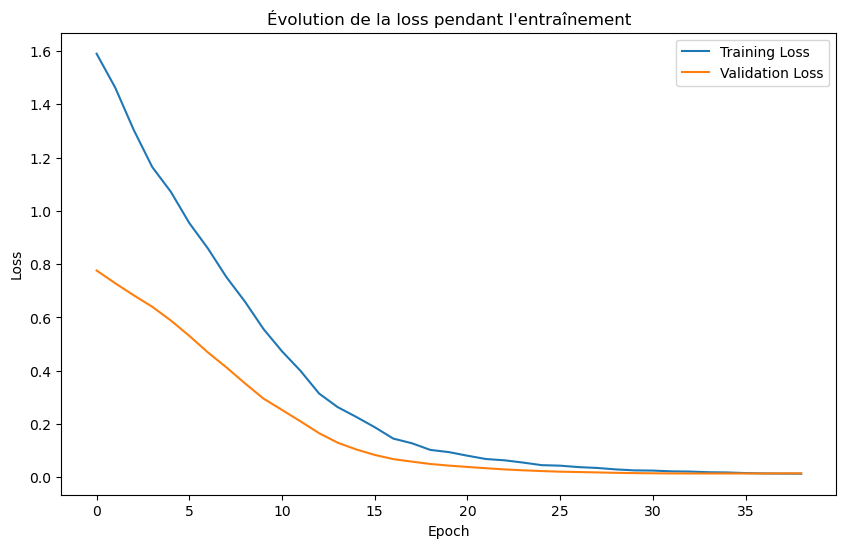

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Score F1 macro : 0.06845096957169709
CSV chargé avec succès. Forme : (1693, 454)
Colonnes : ['name', '64-bit execution via heavens gate', '64bits', 'PEB access', 'accept command line arguments', 'access the Windows event log', 'act as TCP client', 'allocate RW memory', 'allocate RWX memory', 'allocate memory', 'allocate or change RW memory', 'allocate or change RWX memory', 'allocate thread local storage', 'android', 'anorganix', 'apatch', 'apk', 'arm', 'armadillo', 'aspack', 'asprotect', 'assembly', 'attach user process memory', 'attachment', 'authenticate HMAC', 'block operations on executable memory pages using Arbitrary Code Guard', 'bobsoft', 'bypass Windows File Protection', 'calculate modulo 256 via x86 assembly', 'calls-wmi', 'capture screenshot', 'capture screenshot in Go', 'cexe', 'change file permission on Linux', 'change memory protection', 'change the wallpaper', 'check HTTP status code', 'check OS version', 'check ProcessDebugFlags'

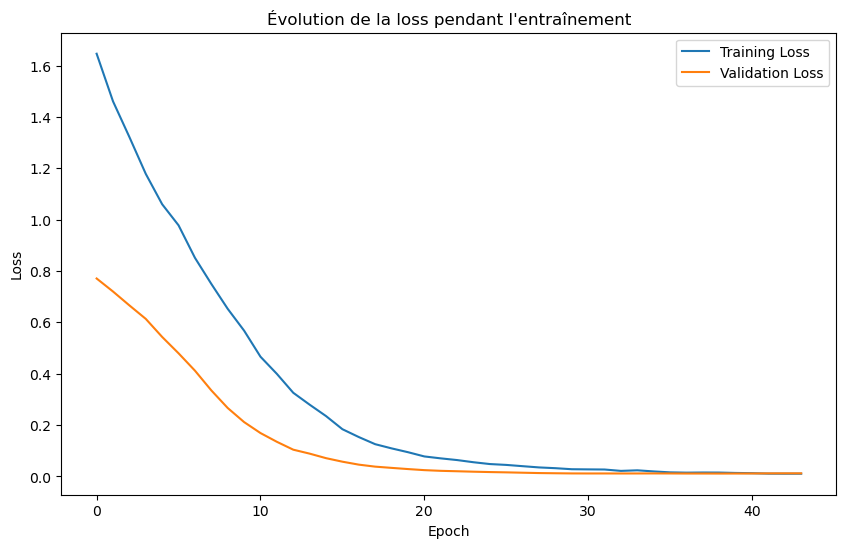

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Score F1 macro : 0.06831659865423684


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.sparse import load_npz, issparse, csr_matrix, save_npz
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# -------------------------
# 1. Fonction de perte Focal Loss
# -------------------------
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = 1e-7
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return focal_loss_fixed

# -------------------------
# 2. Analyse de la distribution des labels
# -------------------------
def compute_label_distribution(y):
    label_freq = np.sum(y, axis=0)
    print("Distribution des labels (occurrences par label) :", label_freq)
    print("Pourcentage moyen d'occurrences par label :", np.mean(label_freq / y.shape[0]))
    return label_freq

# -------------------------
# 3. Chargement et prétraitement des données
# -------------------------
def charger_donnees(csv_path='your_data_updated.csv', 
                    reduced_matrix_path='reduced_tfidf_matrix.npz', 
                    apply_svd=False, 
                    variance_threshold=0.95, 
                    use_smote=False):
    """
    Charge le CSV et la matrice TF-IDF.
      - apply_svd: si True, applique une réduction par Truncated SVD en fonction du seuil de variance.
      - use_smote: si True, applique SMOTE (attention: SMOTE standard n'est pas optimal pour le multi-label).
    Les cibles sont toutes les colonnes du CSV sauf 'name'.
    """
    try:
        # Charger le CSV 
        df = pd.read_csv(csv_path, sep=',')
        print("CSV chargé avec succès. Forme :", df.shape)
        print("Colonnes :", df.columns.tolist())
        
        # Charger la matrice TF-IDF (ou la matrice réduite)
        X = load_npz(reduced_matrix_path)
        print("Matrice TF-IDF chargée de forme :", X.shape)
        if not issparse(X):
            X = csr_matrix(X)
            
        # Si demandé, appliquer SVD pour réduire la dimension
        if apply_svd:
            svd = TruncatedSVD(n_components=min(X.shape[1], 300))
            X_temp = svd.fit_transform(X)
            explained_variance = np.cumsum(svd.explained_variance_ratio_)
            n_components = np.argmax(explained_variance >= variance_threshold) + 1
            print(f"Réduction SVD: {n_components} composantes pour capturer {variance_threshold*100}% de la variance.")
            svd = TruncatedSVD(n_components=n_components)
            X_reduced = svd.fit_transform(X)
            
        else:
            X_reduced = X
            
        # Extraire les cibles : toutes les colonnes sauf 'name'
        if 'name' not in df.columns:
            raise ValueError("La colonne 'name' est introuvable dans le CSV.")
        y = df.drop(columns=['name']).values
        print("Cibles extraites de forme :", y.shape)
        
        # Afficher la distribution des labels
        compute_label_distribution(y)
        
        # Aligner les données si nécessaire
        if X_reduced.shape[0] != y.shape[0]:
            diff = X_reduced.shape[0] - y.shape[0]
            print(f"Alignement: suppression de {diff} lignes de la matrice TF-IDF.")
            X_reduced = X_reduced[:y.shape[0]]
        
        # Idée: SMOTE (par défaut désactivé pour le multi-label car fonctionne pas bien)
        if use_smote:
            from imblearn.over_sampling import SMOTE
            smote = SMOTE(random_state=42)
            X_resampled, y_resampled = smote.fit_resample(X_reduced, y)
        else:
            X_resampled, y_resampled = X_reduced, y
        
        return train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    
    except Exception as e:
        print("Erreur lors du chargement des données :", e)
        return None

# -------------------------
# 4. Création du modèle MLP
# -------------------------
def creer_modele_mlp_optimise(input_dim, output_dim, use_focal_loss=False):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))

    # Ajustement des couches
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(output_dim, activation='sigmoid'))

    if use_focal_loss:
        loss_fn = focal_loss(gamma=2., alpha=0.25)
    else:
        loss_fn = 'binary_crossentropy'

    model.compile(optimizer=Adam(learning_rate=0.0005), loss=loss_fn, metrics=['accuracy'])
    return model

# Entraîner et évaluer le modèle optimisé
donnees = charger_donnees(csv_path='your_data_updated.csv',
                          reduced_matrix_path='reduced_tfidf_matrix.npz',
                          apply_svd=True,
                          variance_threshold=0.95,
                          use_smote=False)

if donnees:
    X_train, X_test, y_train, y_test = donnees
    modele_optimise = entrainer_et_evaluer_modele(X_train, y_train, X_test, y_test, use_focal_loss=True)
else:
    print("Échec du chargement des données.")


# -------------------------
# 5. Visualisation et entraînement
# -------------------------
def visualiser_resultats(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title("Évolution de la loss pendant l'entraînement")
    plt.legend()
    plt.show()

def entrainer_et_evaluer_modele(X_train, y_train, X_test, y_test, use_focal_loss=False):
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]
    print("Dimension d'entrée :", input_dim, "Dimension de sortie :", output_dim)
    
    modele = creer_modele_mlp(input_dim, output_dim, use_focal_loss=use_focal_loss)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = modele.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2,
                         callbacks=[early_stopping], verbose=1)
    
    visualiser_resultats(history)
    
    y_pred = (modele.predict(X_test) > 0.5).astype("int32")
    score = f1_score(y_test, y_pred, average='macro', zero_division=0)
    print("Score F1 macro :", score)
    return modele

# -------------------------
# Exemple d'utilisation
# -------------------------
donnees = charger_donnees(csv_path='your_data_updated.csv', 
                          reduced_matrix_path='reduced_tfidf_matrix.npz', 
                          apply_svd=False,    
                          variance_threshold=0.95, 
                          use_smote=False)     # SMOTE est désactivé par défaut pour le multi-label

if donnees:
    X_train, X_test, y_train, y_test = donnees
    modele = entrainer_et_evaluer_modele(X_train, y_train, X_test, y_test, use_focal_loss=True)
else:
    print("Échec du chargement des données.")



